<a href="https://colab.research.google.com/github/salonisahu1999/Bitcoinpriceprediction/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape
import tensorflow as tf
#from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import GRU, CuDNNGRU
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
#from keras.backend.tensorflow_backend import set_session
from keras import optimizers
from math import sqrt
from numpy import concatenate
from  matplotlib import pyplot 
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
py.init_notebook_mode(connected=True)
from scipy import stats
from tensorflow import keras
import tensorflow_addons as tfa
from prettytable import PrettyTable


%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv(filepath_or_buffer="/content/BTC-USD (3).csv", index_col="Date")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 2019-01-01 to 2021-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       913 non-null    float64
 1   High       913 non-null    float64
 2   Low        913 non-null    float64
 3   Close      913 non-null    float64
 4   Adj Close  913 non-null    float64
 5   Volume     913 non-null    float64
dtypes: float64(6)
memory usage: 50.1+ KB


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,35035.984375,35035.984375,32883.781250,33572.117188,33572.117188,3.783896e+10
2021-07-02,33549.601563,33939.589844,32770.679688,33897.046875,33897.046875,3.872897e+10
2021-07-03,33854.421875,34909.261719,33402.695313,34668.546875,34668.546875,2.438396e+10
2021-07-04,34665.566406,35937.566406,34396.476563,35287.781250,35287.781250,2.492431e+10
2021-07-05,34930.460938,34990.582031,34129.914063,34246.839844,34246.839844,2.435889e+10


In [8]:
btc_trace = go.Scatter(x=data.index, y=data['Adj Close'], name= 'Price')
py.iplot([btc_trace])

In [9]:
data['Adj Close'].replace(0, np.nan, inplace=True)
data['Adj Close'].fillna(method='ffill', inplace=True)

In [10]:
#btc_trace = go.Scatter(x=data.index, y=data['Adj Close'], name= 'Price')
#py.iplot([btc_trace])

In [11]:
from sklearn.preprocessing import MinMaxScaler

values = data['Adj Close'].values.reshape(-1,1)
values = values.astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
print(scaled)

[[7.38800160e-03]
 [9.04994471e-03]
 [7.27521692e-03]
 [7.62421737e-03]
 [7.41586265e-03]
 [1.12664890e-02]
 [1.04115660e-02]
 [1.05047314e-02]
 [1.05787445e-02]
 [4.64949004e-03]
 [4.78992861e-03]
 [4.35627261e-03]
 [2.55359847e-03]
 [5.10083590e-03]
 [3.84672683e-03]
 [4.25155095e-03]
 [4.64349050e-03]
 [4.29867792e-03]
 [5.47545520e-03]
 [3.35322177e-03]
 [2.93758875e-03]
 [3.41251028e-03]
 [3.08883622e-03]
 [3.35075616e-03]
 [3.33246103e-03]
 [3.37729300e-03]
 [3.06958247e-03]
 [1.18093266e-03]
 [8.09351705e-04]
 [1.44266575e-03]
 [9.70335738e-04]
 [1.47200943e-03]
 [2.02297918e-03]
 [1.07383475e-03]
 [9.92985285e-04]
 [1.11283373e-03]
 [2.37856806e-04]
 [0.00000000e+00]
 [4.44743541e-03]
 [4.52103020e-03]
 [4.83689310e-03]
 [4.14213771e-03]
 [4.22695571e-03]
 [3.86994100e-03]
 [3.61721736e-03]
 [3.68260290e-03]
 [3.83195751e-03]
 [4.56483044e-03]
 [8.58915881e-03]
 [9.11125608e-03]
 [9.98850365e-03]
 [9.22811492e-03]
 [1.00834400e-02]
 [1.23628270e-02]
 [6.83741365e-03]
 [8.039809

In [13]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

641 276


In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

640
275


In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
print(trainX.shape)
print(testX.shape)

(640, 1, 1)
(275, 1, 1)


In [18]:
model_adam = Sequential()
model_adam.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_adam.add(Activation('tanh'))
model_adam.add(Dropout(0.2))
model_adam.add(Dense(1))
model_adam.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_adam.compile(loss='mse', optimizer='adam',metrics=["mean_squared_error"])
history_adam= model_adam.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [19]:
test_results_loss = []
test_results_r2score = []
test_results_loss.append(model_adam.evaluate(
    testX, testY, verbose=0))

model_predict = model_adam.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

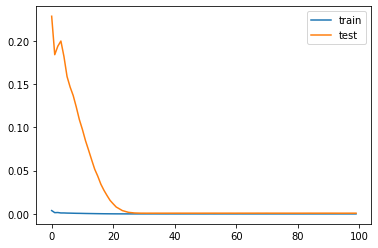

In [20]:
pyplot.plot(history_adam.history['loss'], label='train')
pyplot.plot(history_adam.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

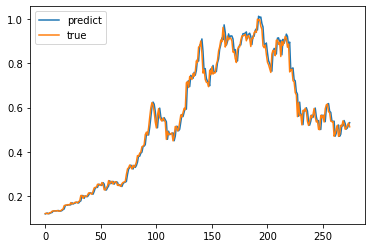

In [21]:
yhat = model_adam.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()


In [22]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

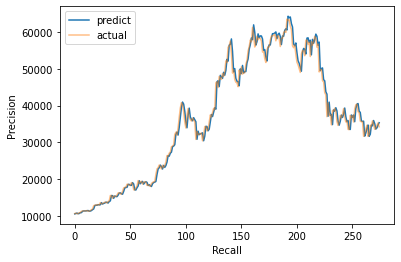

In [23]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [24]:
predictDates = data.tail(len(testX)).index

In [25]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [26]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])
# pyplot.show()

In [27]:
model_sgd = Sequential()
model_sgd.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_sgd.add(Activation('tanh'))
model_sgd.add(Dropout(0.2))
model_sgd.add(Dense(1))
model_sgd.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_sgd.compile(loss='mse', optimizer='sgd',metrics=["mean_squared_error"])
history_sgd= model_sgd.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [28]:
test_results_loss.append(model_sgd.evaluate(
    testX, testY, verbose=0))

model_predict = model_sgd.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [29]:
model_adagrad = Sequential()
model_adagrad.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_adagrad.add(Activation('tanh'))
model_adagrad.add(Dropout(0.2))
model_adagrad.add(Dense(1))
model_adagrad.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_adagrad.compile(loss='mse', optimizer='adagrad',metrics=["mean_squared_error"])
history_adagrad= model_adagrad.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [30]:
test_results_loss.append(model_adagrad.evaluate(
    testX, testY, verbose=0))

model_predict = model_adagrad.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [31]:
model_rmsprop = Sequential()
model_rmsprop.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_rmsprop.add(Activation('tanh'))
model_rmsprop.add(Dropout(0.2))
model_rmsprop.add(Dense(1))
model_rmsprop.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_rmsprop.compile(loss='mse', optimizer='rmsprop',metrics=["mean_squared_error"])
history_rmsprop= model_rmsprop.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [32]:
test_results_loss.append(model_rmsprop.evaluate(
    testX, testY, verbose=0))

model_predict = model_rmsprop.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [33]:
model_adadelta = Sequential()
model_adadelta.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_adadelta.add(Activation('tanh'))
model_adadelta.add(Dropout(0.2))
model_adadelta.add(Dense(1))
model_adadelta.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_adadelta.compile(loss='mse', optimizer='adadelta',metrics=["mean_squared_error"])
history_adadelta= model_adadelta.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [34]:
test_results_loss.append(model_adadelta.evaluate(
    testX, testY, verbose=0))

model_predict = model_adadelta.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [35]:
model_nadam = Sequential()
model_nadam.add(GRU(units=100, activation=None, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model_nadam.add(Activation('tanh'))
model_nadam.add(Dropout(0.2))
model_nadam.add(Dense(1))
model_nadam.add(Activation('relu'))
#model_gru.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-32-0.00004.hdf5')
model_nadam.compile(loss='mse', optimizer='nadam',metrics=["mean_squared_error"])
history_nadam= model_nadam.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [36]:
test_results_loss.append(model_nadam.evaluate(
    testX, testY, verbose=0))

model_predict = model_nadam.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

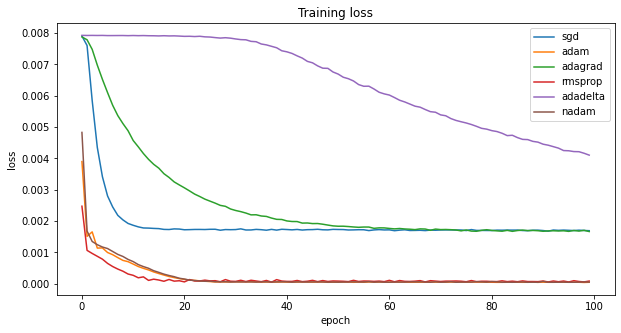

In [37]:
pyplot.figure(figsize=(10, 5))  

pyplot.plot(history_sgd.history['loss'])  
pyplot.plot(history_adam.history['loss']) 
pyplot.plot(history_adagrad.history['loss'])
pyplot.plot(history_rmsprop.history['loss'])
pyplot.plot(history_adadelta.history['loss'])
pyplot.plot(history_nadam.history['loss'])  
pyplot.title('Training loss')  
pyplot.ylabel('loss')  
pyplot.xlabel('epoch') 
pyplot.legend(['sgd','adam','adagrad','rmsprop','adadelta','nadam'], loc='upper right')  

pyplot.show()

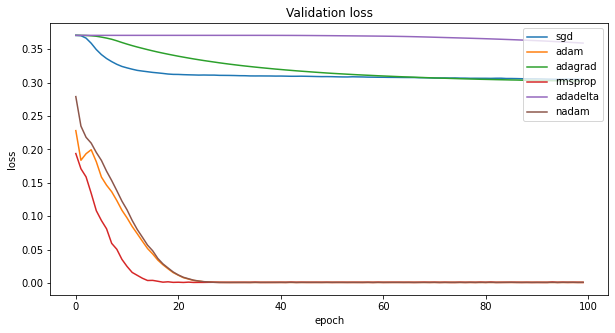

In [38]:
pyplot.figure(figsize=(10, 5))  

pyplot.plot(history_sgd.history['val_loss'])  
pyplot.plot(history_adam.history['val_loss']) 
pyplot.plot(history_adagrad.history['val_loss'])
pyplot.plot(history_rmsprop.history['val_loss'])
pyplot.plot(history_adadelta.history['val_loss'])
pyplot.plot(history_nadam.history['val_loss'])  
pyplot.title('Validation loss')  
pyplot.ylabel('loss')  
pyplot.xlabel('epoch') 
pyplot.legend(['sgd','adam','adagrad','rmsprop','adadelta','nadam'], loc='upper right')  

pyplot.show()

In [39]:
optimizers = ['Adam','SGD','Adagrad','RmsProp','Adadelta','Nadam']
t = PrettyTable(['Optimizers', 'MSE', 'RSquare'])

#Loop to display the predictor combinations along with the MSE value of the corresponding model
for i in range(len(test_results_loss)):
    t.add_row([optimizers[i],test_results_loss[i],test_results_r2score[i]])
print(t)

+------------+------------------------------------------------+------------+
| Optimizers |                      MSE                       |  RSquare   |
+------------+------------------------------------------------+------------+
|    Adam    | [0.0009018105338327587, 0.0009018105338327587] | 0.9876069  |
|    SGD     |    [0.3050421178340912, 0.3050421178340912]    | -6685.351  |
|  Adagrad   |    [0.3021848797798157, 0.3021848797798157]    | -13441.224 |
|  RmsProp   | [0.0008701731567271054, 0.0008701731567271054] | 0.9876871  |
|  Adadelta  |   [0.35927969217300415, 0.35927969217300415]   | -4507.3745 |
|   Nadam    | [0.0010972669115290046, 0.0010972669115290046] | 0.9853711  |
+------------+------------------------------------------------+------------+


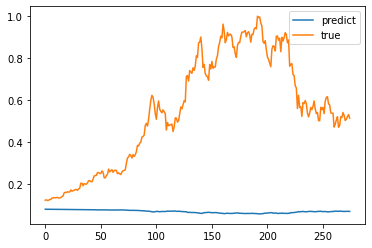

In [40]:
#SGD
yhat = model_sgd.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [41]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

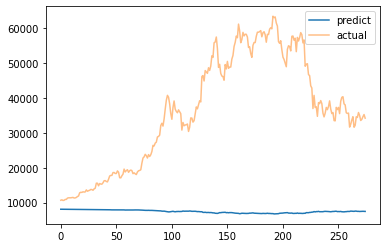

In [42]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

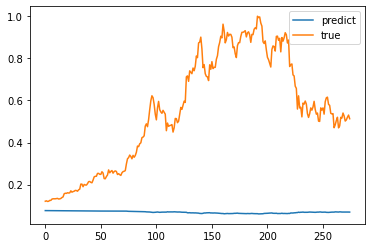

In [43]:
#ADAGRAD
yhat = model_adagrad.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [44]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

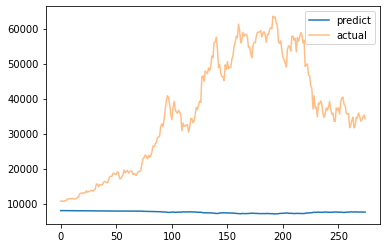

In [45]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

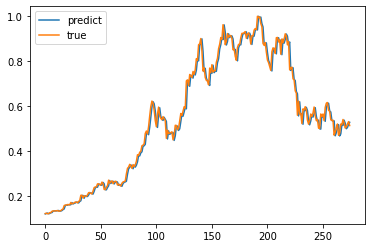

In [46]:
#RMSPROP
yhat = model_rmsprop.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [47]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

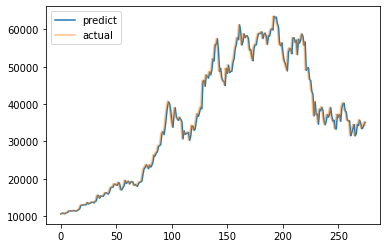

In [48]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

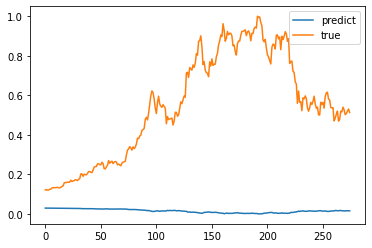

In [49]:
#ADADELTA
yhat = model_adadelta.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [50]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

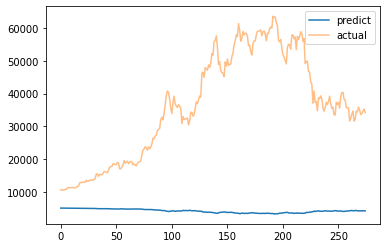

In [51]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

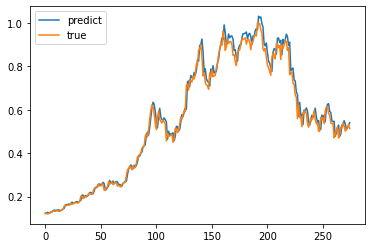

In [52]:
#NADAM
yhat = model_nadam.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [53]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

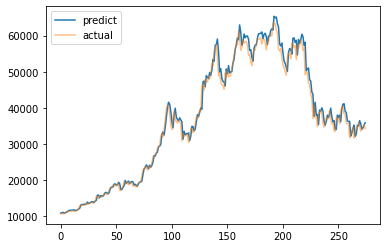

In [54]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()